In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt

# Fertility Dataset

## Preprocessing

In [113]:
data_path = r'data/fertility_diagnosis.csv'
df = pd.read_csv(data_path)
df = dpu.preprocess_fertility_dataset(df)

In [114]:
nn = NNFramework()
nn.fit_encoder(df=df, cols_to_encode=df.columns.difference(['age', 'hours_sitting']))
df_encoded = nn.encode_dataset(df)

In [115]:
len(df_encoded.columns)

21

## Parameter experiments

In [116]:
random_seed = 1038
scaling = True
oversampling = True

scaler = preprocessing.StandardScaler() if scaling else None

In [117]:
y = df_encoded['diagnosis']
X = df_encoded[df_encoded.columns.difference(['diagnosis'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)


Params to check out:
- RELU
- sigmoid
- number of layers
- number of nodes per layer
- 

In [143]:
methods = [
        ('MLP-relu-1-5', MLP(activation_function='relu', hidden_layer_sizes=(5,))),
        ('MLP-sigmoid-1-5', MLP(activation_function='sigmoid', hidden_layer_sizes=(5,))),
        ('MLP-relu-1-10', MLP(activation_function='relu', hidden_layer_sizes=(10,))),
        ('MLP-sigmoid-1-10', MLP(activation_function='sigmoid', hidden_layer_sizes=(10,))),
        ('MLP-relu-1-40', MLP(activation_function='relu', hidden_layer_sizes=(40,))),
        ('MLP-sigmoid-1-40', MLP(activation_function='sigmoid', hidden_layer_sizes=(40,))),
        ('MLP-relu-2-10', MLP(activation_function='relu', hidden_layer_sizes=(10, 10))),
        ('MLP-sigmoid-2-10', MLP(activation_function='sigmoid', hidden_layer_sizes=(10, 10))),
        ('MLP-relu-2-40', MLP(activation_function='relu', hidden_layer_sizes=(40, 40))),
        ('MLP-sigmoid-2-40', MLP(activation_function='sigmoid', hidden_layer_sizes=(40, 40))),
        ('MLP-relu-5-10', MLP(activation_function='relu', hidden_layer_sizes=(10, 10, 10, 10, 10))),
        ('MLP-sigmoid-5-10', MLP(activation_function='sigmoid', hidden_layer_sizes=(10, 10, 10, 10, 10))),
    ]
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

In [144]:
model_params = {}
for model_name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro', n_jobs=-1)

    model_params[model_name] = {}
    model_params[model_name]['f_scores'] = scores
    model_params[model_name]['f_scores_mean'] = scores.mean()
    model_params[model_name]['f_scores_std'] = scores.std()

    print(model_name)
    print(
        f"f1 scores: {model_params[model_name]['f_scores']}\n" +
        f"f1 mean: {model_params[model_name]['f_scores_mean']:.3f}\n" +
        f"f1 std: {model_params[model_name]['f_scores_std']:.3f}\n"
    )
    print('----------------------------------------------------------------------------------------------------')
    

MLP-relu-1-5
f1 scores: [0.35483871 0.74025974 0.60784314 0.53125    0.44444444]
f1 mean: 0.536
f1 std: 0.133

----------------------------------------------------------------------------------------------------
MLP-sigmoid-1-5
f1 scores: [0.34065934 0.65714286 0.60784314 0.375      0.41176471]
f1 mean: 0.478
f1 std: 0.129

----------------------------------------------------------------------------------------------------
MLP-relu-1-10
f1 scores: [0.43573668 0.49820789 0.56709957 0.42857143 0.41176471]
f1 mean: 0.468
f1 std: 0.057

----------------------------------------------------------------------------------------------------
MLP-sigmoid-1-10
f1 scores: [0.37321937 0.80392157 0.42857143 0.42857143 0.41176471]
f1 mean: 0.489
f1 std: 0.159

----------------------------------------------------------------------------------------------------
MLP-relu-1-40
f1 scores: [0.35483871 0.60784314 0.53125    0.42857143 0.42857143]
f1 mean: 0.470
f1 std: 0.089

--------------------------------

In [147]:
df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

df_param['activation_function'] = df_param.model.str.extract(r'MLP-(\w+)-.*')
df_param['layer_num'] = df_param.model.str.extract(r'MLP-\w+-(\d+).*')
df_param['layer_sizes'] = df_param.model.str.extract(r'MLP-\w+-\d-(\d+)')

df_param

,model,f_scores,f_scores_mean,f_scores_std,activation_function,layer_num,layer_sizes
0,MLP-relu-1-5,"[0.3548387096774194, 0.7402597402597403, 0.607...",0.535727,0.132746,relu,1,5
1,MLP-sigmoid-1-5,"[0.34065934065934067, 0.6571428571428571, 0.60...",0.478482,0.128693,sigmoid,1,5
2,MLP-relu-1-10,"[0.43573667711598746, 0.4982078853046595, 0.56...",0.468276,0.05743,relu,1,10
3,MLP-sigmoid-1-10,"[0.3732193732193732, 0.803921568627451, 0.4285...",0.48921,0.15865,sigmoid,1,10
4,MLP-relu-1-40,"[0.3548387096774194, 0.6078431372549019, 0.531...",0.470215,0.088822,relu,1,40
5,MLP-sigmoid-1-40,"[0.30666666666666664, 0.6571428571428571, 0.41...",0.467323,0.126704,sigmoid,1,40
6,MLP-relu-2-10,"[0.375, 0.29292929292929293, 0.248120300751879...",0.33117,0.056056,relu,2,10
7,MLP-sigmoid-2-10,"[0.27083333333333337, 0.4736842105263158, 0.45...",0.405298,0.072611,sigmoid,2,10
8,MLP-relu-2-40,"[0.375, 0.14786967418546365, 0.147869674185463...",0.314929,0.139348,relu,2,40
9,MLP-sigmoid-2-40,"[0.4736842105263158, 0.4736842105263158, 0.473...",0.467994,0.006969,sigmoid,2,40


<Axes: xlabel='layer_sizes', ylabel='f_scores_mean'>

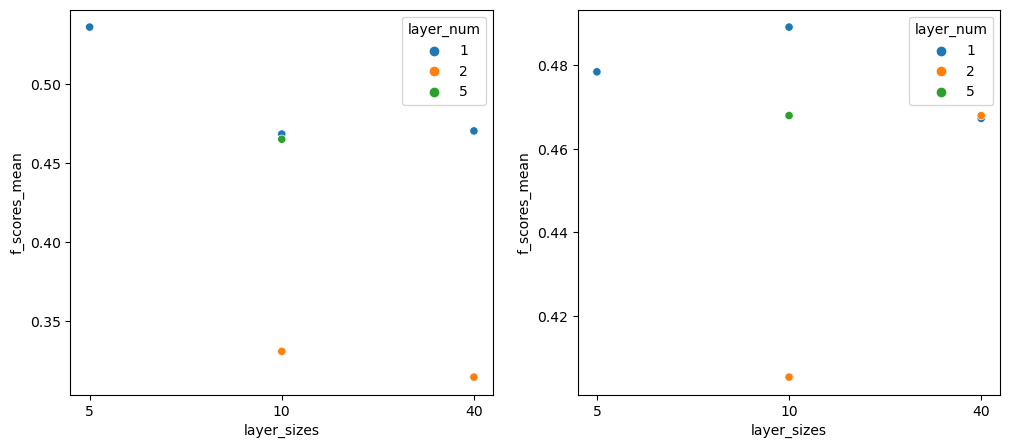

In [164]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_param[df_param.activation_function == 'relu'], x='layer_sizes', y='f_scores_mean', hue='layer_num', ax=axes[0])
sns.scatterplot(data=df_param[df_param.activation_function == 'sigmoid'], x='layer_sizes', y='f_scores_mean', hue='layer_num', ax=axes[1])

## Comparison 